# STA561 FINAL

# Zhen Han Si 

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model,Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPooling2D,BatchNormalization,UpSampling3D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.mlab as mlab
from mlxtend.data import loadlocal_mnist
from sklearn.manifold import SpectralEmbedding
import time 
from mpl_toolkits.mplot3d import Axes3D
from keras import layers
from keras import backend as K 

## Question 1.1.1

### Gaussian Process part 

In [32]:
ad = pd.read_csv('Ad.csv')

I first tried the Gaussian Process model with the RBF kernel (exponential kernel) and do the leave one out cross validation. The error is calculated by (real_y_test - predict_y_test)^2 and I get the result of around 21. This is a very bad error for this dataset but I felt that I can improve the result by changing the kernel of Gaussian Process. Since exponential kernel is only a fundamental kernel for the gaussian process, changing to some other combination kernel may improve the performance of the prediction.

So the kernel I use is kernel = ConstantKernel(1.0) + RBF(np.ones(3)) and yields the error of:

In [33]:
X = ad.iloc[:,:3]
y = ad['sales']
# set the kernel to be the exponential kernel 
kernel = ConstantKernel(1.0) + RBF(np.ones(3))
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)

In [136]:
error = 0
mean = []
sd = []
for i in range(len(y)):
    #prepare the train set and the test point
    X_train = X[~X.index.isin([i])]
    y_train = y[~y.index.isin([i])]
    X_test = X.iloc[i,:]
    X_test = np.array(X_test)
    X_test = X_test.reshape(1,3)
    X_test = pd.DataFrame(X_test)
    y_test = y[i]
    # fit the gaussian process model 
    gp.fit(X_train, y_train)
    # get the prediction and the standard deviation 
    pred, sigma = gp.predict(X_test, return_std=True)
    # calculate the current add up error 
    error += (y_test-pred)**2
    # This is for later question to draw the confidence interval 
    if i == 0 or i == 49 or i == 99 or i == 149:
        mean.append(pred)
        sd.append(sigma)
error/len(y)

array([21.07274846])

In order to improve the performance, I decide to change the kernel. The gaussian process kernel in sklearn can be additive component kernel. So I include a constant kernel, a Matern component and an observation noise to the original exponential kernel. Then I run the new gaussian process leave one out cross validation and find out that the new error is only around 0.347. This is a huge improvement than the previous kernel so I decide to use this combination kernel as my final kernel for the gaussian process model.

The current kernel I try is: kernel = ConstantKernel() + Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) + RBF(np.ones(3)) and yields the error of :

In [40]:
kernel = ConstantKernel() + Matern(length_scale=3, nu=3/2) + WhiteKernel(noise_level=1) + RBF(np.ones(3))
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)

In [41]:
error = 0
mean = []
sd = []
for i in range(len(y)):
    # prepare the data 
    X_train = X[~X.index.isin([i])]
    y_train = y[~y.index.isin([i])]
    X_test = X.iloc[i,:]
    X_test = np.array(X_test)
    X_test = X_test.reshape(1,3)
    X_test = pd.DataFrame(X_test)
    y_test = y[i]
    # fit the gaussian model with the new kernel 
    gp.fit(X_train, y_train)
    pred, sigma = gp.predict(X_test, return_std=True)
    # calculate the new error term 
    error += (y_test-pred)**2
    if i == 0 or i == 49 or i == 99 or i == 149:
        mean.append(pred)
        sd.append(sigma)
error/len(y)

array([0.34732683])

### CNN part

Then I tried to use the CNN to solve that problem. The hardest part is the tuning of cnn model. Because CNN has a very large degree of freedom: The number of layers, combination of layers, number of neurons in each layer, other parameters in each layer, activation functions, etc. There are so many parameters that we can tune for every neural network model.

I tuned a lot of model for this question, but in order to save the space, I only put my final model here. Surprisingly, putting so many layers here yield a bad result. One convolutional layer and one dense layer yield the lowest error. 

The first is the convolutional layer with kernel size (3,1)  with the relu activation function. Since we dont have much variables I did not put maxpooling here. Then a 1028 neuron dense layer with relu activation function. 

For each leave one out cross validation, I make last 49 data to be the validation data because I discovered that including validation data into training can significantly reduce overfitting problem. At last the error is only about 0.189, this is a very low value proving that my model is pretty significant. 

In [34]:
#redifine x and y 
X = ad.iloc[:,1:4]
y = ad['sales']

In [35]:
model1 = Sequential()# define the model 

model1.add(Conv2D(64, kernel_size=(3, 1),activation='relu',input_shape=(3, 1, 1)))
model1.add(Flatten())

model1.add(Dense(1028,activation='relu'))
model1.add(Dense(1,activation='relu'))

# define the loss, optimizer and metrics. 
model1.compile(loss=keras.losses.mean_squared_error,
              optimizer='adam')


In [39]:
error_cnn = 0
for i in range(len(y)):
    # prepare the data
    X_train = X[~X.index.isin([i])]
    X_train = np.array(X_train)
    X_train = X_train.reshape(199,3,1,1)
    y_train = y[~y.index.isin([i])]
    X_train2 = X_train[:150]
    valid_x = X_train[150:]
    y_train2 = y_train[:150]
    valid_y = y_train[150:]
    
    X_test = X.iloc[i,:]
    X_test = np.array(X_test).reshape(1,3,1,1)
    y_test = np.array(y[i])
    t_model1 = model1.fit(X_train2, y_train2,
                  batch_size=100,
                  epochs=60,
                  verbose=0,
                  validation_data=(valid_x, valid_y))
    pred = model1.predict(X_test).reshape((1,))  
    # calculate the new error term
    error_cnn += (y_test-pred)**2
error_cnn/len(y)

array([0.18962179], dtype=float32)

## Question 1.1.2

I draw the predictive posterior distributions for observations 1,50,100 and 150 for both Gaussian Process. I also plot the predictive mean(which is the prediction) and the 2.5% percentile and 97.5% percentile. 

The responses for gaussian process are:

observation1: 21.52626584

observation50: 9.75984407

observation100: 17.82105027

observation150: 10.21812234

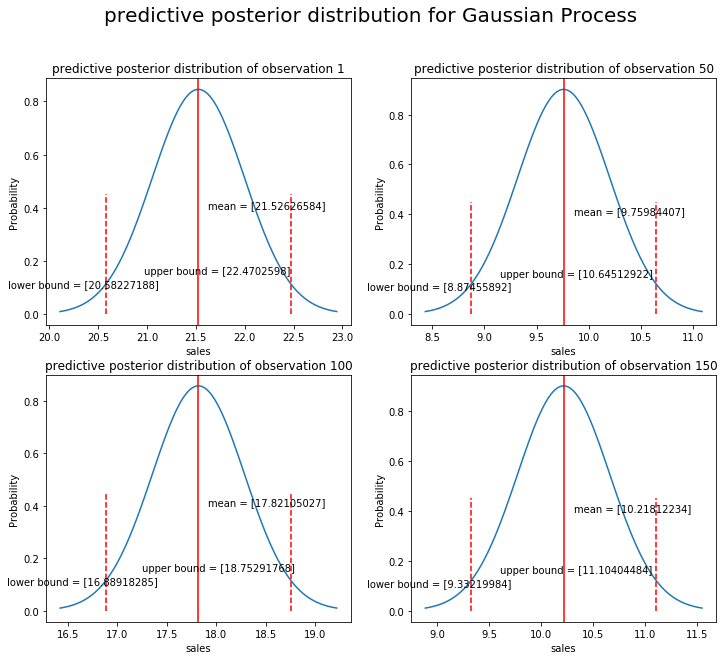

In [46]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(12,10))
fig.suptitle('predictive posterior distribution for Gaussian Process', fontsize=20)
l = [1,50,100,150]
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    # get the corrsponding mu and sd from previously stored values
    mu = mean[i]
    sigma = sd[i]
    # construct the x
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    # draw the normal distribution according to mu and sd 
    ax.plot(x,mlab.normpdf(x, mu, sigma))
    ax.set_title("predictive posterior distribution of observation {0}".format(l[i]))
    ax.set_ylabel("Probability")
    ax.set_xlabel("sales")
    ax.axvline(mu, color='r')
    ax.text(mu+0.1,0.4,'mean = {0}'.format(mu),rotation=0)
    # add the mean 
    ax.vlines(mu-2*sigma,0,0.45,color='r',linestyles='dashed')
    ax.text(mu-2*sigma-1,0.1,'lower bound = {0}'.format(mu-2*sigma),rotation=0)
    # add the percentiles 
    ax.vlines(mu+2*sigma,0,0.45,color='r',linestyles='dashed')
    ax.text(mu+2*sigma-1.5,0.15,'upper bound = {0}'.format(mu+2*sigma),rotation=0)
plt.show()

## question 1.2.1

For the first part of the question, I use the Spectral Embedding function from sklearn to project the original data (28x28 columns) into 3 dimensions (3 columns). Because the dataset is too large, and the projection of too many data will make the final plot looks very messy. Therefore, I only choose first 1000 data to be projected. 

The idea is the same if I want to use the whole dataset, but too many points and labels will make the plot very unclear. I didnt show all points' labels becasue too many labels will also make the plots very messy. I show the label every 10 points and it can include all label areas. 

I use the Matplotlib axe3d to plot the final clusters and we can see that our model is pretty good. The points distributed into different clusters. 

In [233]:
X, y = loadlocal_mnist(
        images_path='train-images-idx3-ubyte',
        labels_path='train-labels-idx1-ubyte') #load the dataset 
y  = y.reshape(60000,1)
X = X[:1000,:] #choose only first 1000 points 
y = y[:1000]

In [136]:
# build the model
embed = SpectralEmbedding(n_components=3, random_state=20212021,eigen_solver="arpack")
# train the model 
X_3dim = embed.fit_transform(X)

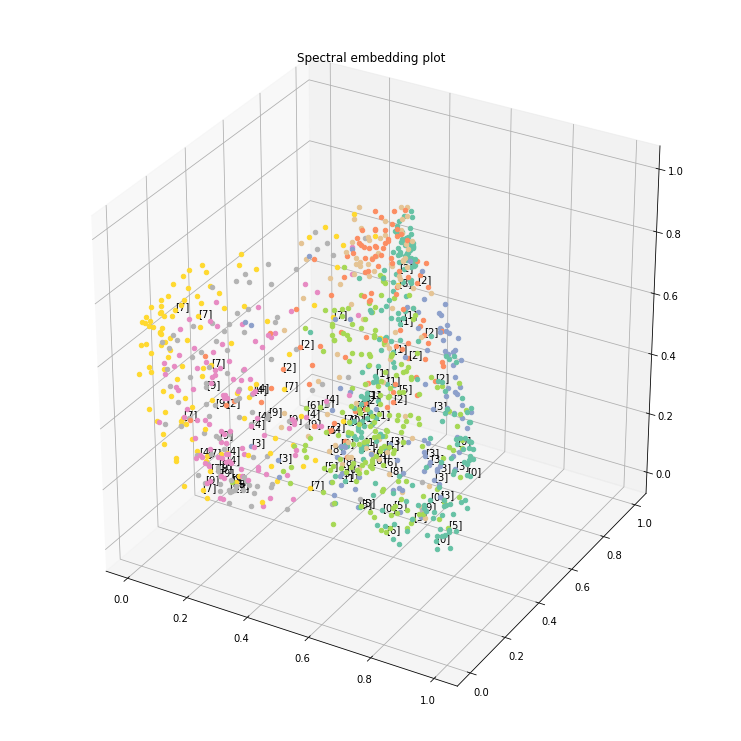

embedding shape:  (1000, 3)


In [138]:
# select the minimum and maximum points in order to draw the plot 
x_min = np.min(X_3dim, 0)
x_max = np.max(X_3dim, 0)
# Normalize Xs 
X2 = (X_3dim - x_min) / (x_max - x_min)
fig = plt.figure(figsize=(10,10))
# construct the 3d ax
ax = Axes3D(fig)
for i in range(1000):
    #get the color sets 
    rgb = plt.cm.Set2(y[i] / 10.)[0,:3]
    # plot the points
    ax.scatter3D(X2[i,0],X2[i,1], X2[i,2], color=rgb)
    if i%10 == 0:
        #plot the labels 
        ax.text(X2[i,0], X2[i,1], X2[i,2], str(y[i]))
plt.title('Spectral embedding plot')
plt.show()

print("embedding shape: " ,X_3dim.shape)

## question 1.2.2

The encoder is more complicated than the spectral embedding, but it also yields a better result. The core idea of this encoder is to build a CNN to encode the plot into 3 dimensions and sample a data and use the opposite of the encoder to build a decoder to get the decoded result. Compare the error between original plot and the decoded plot to train the parameters in order to get a best encoder. 

First step is to build a encoder. For here I did not use the sequential method to build CNN because I have to define different models by myself in the later stages. 

Tuning parameter is time costly and boring so I also only shows my final model here: I use two layers convolutional net with 32 neurons and 64 neurons. Still using the relu activation. I have to save a shape of conv net using in decoders in the later stage. After the conv layer it's a single dense layer. I didnt any dropout term because the goal of this question is projection so I dont need any test data. Overfitting is not a problem. 

At last the output of encoder is 3 dimensional z_mu and z_sigma 

In [521]:
# start the model, define the input
input_img = keras.Input(shape=(28, 28, 1))

# two conv layers
x = layers.Conv2D(32, 3, padding='same',activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same',activation='relu')(x)
# record the current shape using in decoder stage
record = K.int_shape(x)

# one dense layer
x_dense = layers.Flatten()(x)
x_dense = layers.Dense(512, activation='relu')(x_dense)

# result layer 
z_mu = layers.Dense(3)(x_dense)
z_sigma = layers.Dense(3)(x_dense)

Then I sample the data points based on the z_mu and z_sigma I get from the previous encoder. This is used for decoder and error trainings. 

In [522]:
def sample(a):
    z_mu,z_sigma = a
    #define the epsilon 
    ep = K.random_normal((K.shape(z_mu)[0], 3),0.,1.)
    return ep * K.exp(z_sigma) + z_mu

z = layers.Lambda(sample)([z_mu, z_sigma])

Then it's the decoder stage. The input of the decoder is just the sample data set and inside the model is just the opposite of the encoder.

In [523]:
#define the input 
d_input = layers.Input(K.int_shape(z)[1:])

#opposite of encoder, first start with dense (last stage in encoder)
x = layers.Dense(np.prod(record[1:]),activation='relu')(d_input)
# get back to the shape recorded before 
x = layers.Reshape(record[1:])(x)

#two conv layers
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(1, 1,padding='same', activation='sigmoid')(x)

#define the decoder model here(the neural net starting with d_input and end with x)
decoder = Model(d_input, x)

#decoded sampled data 
z_decoded = decoder(z)

Final we have to add a variational layer because the loss for the encoder problem we cannot simply use the loss provided in keras or tensorflow. We have to use the combination of cross entropy loss and KL divergence loss. So that's more complicated and I have to define the loss here by myself. 

This layer is just used for the loss calculation and used to optimize the parameters. 

In [524]:
class variationalLayer(keras.layers.Layer):

    def loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # that's the formula for the loss of encoders: 
        return K.mean(keras.metrics.binary_crossentropy(x, z_decoded) + (-5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)))

    def call(self, inputs):
        # call the loss function when running this layer 
        x, z_decoded = inputs[0], inputs[1]
        loss_value = self.loss(x, z_decoded)
        self.add_loss(loss_value, inputs=inputs)
        return x

In [525]:
risk = variationalLayer()([input_img, z_decoded]) # add the variational layer into the model 

Then I train the model with the model tarting with very beginning end with loss calculation. I only choose 1000 points here with the same reason above. I dont want my final plot to be very messy. I normalize the data in order to get a better result from my CNN. I choose 20 iterations and 64 batch size. 

After I have trained all my parameters I defined my final encoder model which start with the very beginning and ends with z_mu which is the result of the projection data into 3 dimensions. I plot the prediction clusters using the same method as above and we can see from the plot below the result is better than the spectral embedding. This may due to that encoder model is more accurate than the spectral embedding model. 

In [526]:
model3 = Model(input_img, risk) # the parameter tuning model starting with very beginning end with loss calculation 
model3.compile(optimizer='rmsprop', loss=None)

/Users/ricky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Output "variational_layer_20" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_layer_20" during training.
  


In [527]:
X_train = X/255
X_train = X_train.reshape(1000,28,28,1)

In [528]:
model3.fit(x=X_train, y=None,
        shuffle=True,
        epochs=20,
        batch_size=64)

Epoch 1/20
1000/1000 [==============================] - 16s 16ms/step - loss: 0.4500
Epoch 2/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2894
Epoch 3/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2616
Epoch 4/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2459
Epoch 5/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2327
Epoch 6/20
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2218
Epoch 7/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2136
Epoch 8/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2100
Epoch 9/20
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2074
Epoch 10/20
1000/1000 [==============================] - 17s 17ms/step - loss: 0.2019
Epoch 11/20
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2001
Epoch 12/20
1000/1000 [==============================] - 13s 13

In [532]:
encoder = Model(input_img, z_mu)
pred = encoder.predict(X_train, batch_size=64)

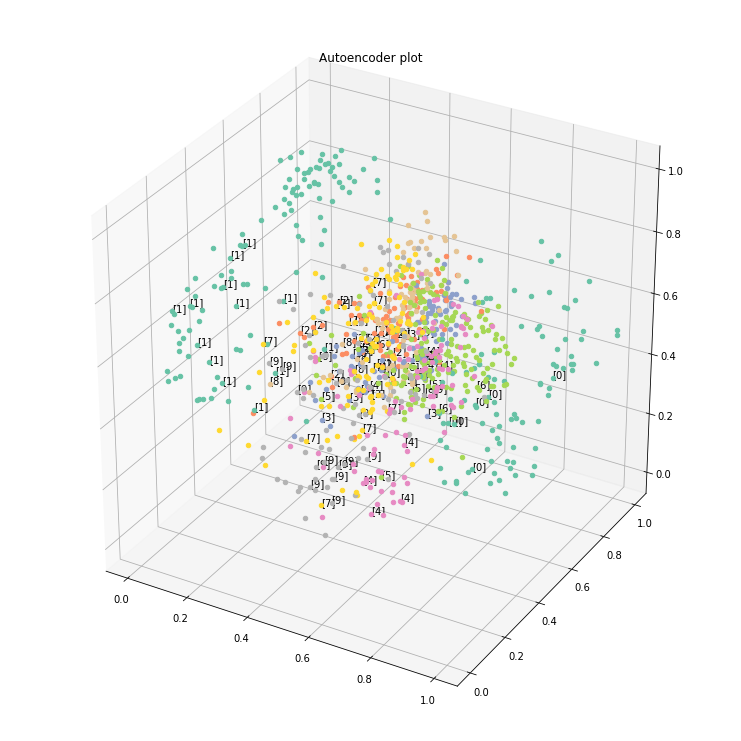

embedding shape:  (1000, 3)


In [531]:
x_min = np.min(pred, 0)
x_max = np.max(pred, 0)
X2 = (pred - x_min) / (x_max - x_min)
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
for i in range(1000):
    rgb = plt.cm.Set2(y[i] / 10.)[0,:3]
    ax.scatter3D(X2[i,0],X2[i,1], X2[i,2], color=rgb)
    if i%10 == 0:
        ax.text(X2[i,0], X2[i,1], X2[i,2], str(y[i]))
plt.title('Autoencoder plot')
plt.show()

print("embedding shape: " ,pred.shape)

## question 1.3

First denote what the generalization error is for here: For the algorithm A we implement at iteration T over n training samples in the function Space $F_c$ = {$f\in F, N(f) \leq c$} for some constant c, the generalization error is:

$\epsilon(A,n,F_c,T)$ = $R(f_T(A, n, F_c)) − R(f^*)$ 

which $f_T$ is the current model current procedure and $f^*$ is the optimal expected risk.

There are two risks: R(f) denote the expected risk which is unknown and equals to E(l(f,z)) which l(f,z) is the loss function.

And the $R_S$(f) denoted the emperical risk which we can know from our observations which is $\frac{1}{n}\sum l(f,z)$

There are several parameters:

$f^*$ denote the optimal expected risk f which is $argmin_fR(f)$

$f^*_{S,F_c}$ denoted the optimal emperical risk f in $F_c$ which is $argmin_{f\in F_c}R_S(f)$

$f^*_{F_c}$ denote the optimal expected risk f in $F_c$ which is $argmin_{f\in F_c}R(f)$


Therefore, we can decompose our generalization error:

$\epsilon(A,n,F_c,T)$ = $R(f_T(A, n, F_c)) − R(f^*)$ 

= $R(f_T) - R(f^*_{S,F_c}) + R(f^*_{S,F_c}) - R(f^*_{F_c}) + R(f^*_{F_c}) - R(f^*)$

= $\epsilon_{opt}(A,n,F_c,T) + \epsilon_{est}(n,F_c) + \epsilon_{app}(F_c)$

The first item $\epsilon_{opt}(A,n,F_c,T) = R(f_T) - R(f^*_{S,F_c})$ is the optimization error, measuring the sub-optimally of the optimzation algorithm under the measurement of the expected risk. It's the difference between the current algorithm and the optimal emperical risk f. It is usually caused by that the resources (computation) being limited. It's the error causing by that the current algorithm is not optimized. If $f_T$ is convex and T is sufficiently large and it's going to converge, then the optimization error will be converge to 0. 

The second item $\epsilon_{est}(n,F_c) = R(f^*_{S,F_c}) - R(f^*_{F_c})$ is the estimation error. It's usually caused by the limiting amount of training data so there's a difference between the optimal emperical risk and the expected risk. If we increasing the size of n and train more, the optimal emperical risk will be converge to the optimal expected risk and the estimation error will tend to be 0.

The third item $\epsilon_{app}(F_c) = R(f^*_{F_c}) - R(f^*)$ is the approximation error, this is usually caused by the limiting representation power of space $F_c$. It has the probability that $f^*$ is not included in $F_c$, causing large approximation error. But if the choice of $F_c$ is good enough, or in other words broad enough (sufficiently large c), it will be a big probability that $f^*$ is in $F_c$ or the value very similar to $f^*$ is in $F_c$, making the estimation error tend to be 0.

Therefore, we see that we can decompose the generalized error into three parts: approximation error, estimation
error, and optimization error.

reference； https://arxiv.org/pdf/1609.08397.pdf

## Question 1.4

First define the Parameters:

The topic distribution for each document is distributed as:

$\theta \sim Dirichlet(\alpha)$

and the word distribution is:

$\phi \sim Dirichlet(\beta)$

The most important goal of LDA is to estimate $\theta$ and $\phi$, which is equal to say the distribution of topics over each document and the distribution of words over each topics. 

$\alpha$ and $\beta$ are the prior parameters which means how narrow or spread the document topic distribution and topic word distributions are.

The firt step of the algorithm is to go through each documents and randomly assign each words in the documents to one of the topics. We are going to genearte a topic assignment list and also a word topic matrix (assignment of each words to each topic) and a document topic matrix (distribution of topic assignment list). The last two matrices are very important and we are going to use and update them throughtout the algorithm. 

The gibbs Sampling works by sample each variables by giving all other variables in the full conditional distributions. In short, if we have three variables x1,x2 and x3. Every iterations, we update x1 by x2 and x3 from the last iterations by the full conditional distribution of x1, and updating x2 by x1 from this iteration and x3 from last iterations, and updating x3 from x1 and x2 in this iteration. 

The full conditional distributions are basically like:

$p(z_{iv}=k|\theta_i,\phi_k) \propto exp(log\theta_{ik}+log\phi_{k,y_{iv}})$ (z represents words) 

$p(\theta_i|z_{iv}=k,b_k) = Dir(\alpha + \sum 1(z_{il}=k))$

$p(\phi_k|z_{iv}=k,\theta_i) = Dir(\beta + \sum\sum 1(y_{il}=v,z_{il}=k))$

Above is the rough draft on how the gibbs sampling work on LDA parameters updating, the more specific is:

$p(z_i=j|z_{-i},w_i,d_i) = \frac{C_{w_ij}^{WT}+\beta}{\sum_{w=1}^{W}C_{wj}^{WT}+W_{\beta}} x \frac{C_{d_ij}^{DT}+\alpha}{\sum_{t=1}^{T}C_{dt}^{DT}+T_{\alpha}}$

where $C^{WT}$ is the word-topic matrix and $C^{DT}$ is the document-topic matrix. W is the total number of words in the whole set of documents (Number of vocabs) and T is the number of topics. $w_i$ is the word index of ith token and $d_i$ is the document containing the ith token. 

$\theta_{dj} = \frac{C_{d_ij}^{DT}+\alpha}{\sum_{k=1}^{T}C_{dk}^{DT}+T_{\alpha}}$

$\phi_{ij} = \frac{C_{w_ij}^{WT}+\beta}{\sum_{k=1}^{W}C_{kj}^{WT}+W_{\beta}}$


Keep updating until convergence of three parameters and output the final result. 

## Question 1.5 

In [536]:
# read the dataset using the code in the website 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [537]:
d = unpickle('data_batch_1')

In [538]:
labels = d[b'labels']
df = d[b'data']

## CNN part 

For this question, I use the first 1000 data from the dataset. Because leave one out cross validation takes a lot of time to run, even with only 1000 data points I have to train 1000 deep learning models and it costs more than 8 hour to fit the model.

I will not replicate what I have mentioned above about the tuning of the CNN model, I just introduced my final model here:

This is a simple model with only two layers: one convolutional layer and one dense layer. The convolutional layer with 32 neurons and (3,3) kernel size, the input shape is 32,32,3 because that's the dimension of data. I followed a max_pooling and batch_normalization because max_pooling is very useful for image recognization(many pixel information are actually useless). I use batch normalization because the dataset is not normalized yet and normalization can significantly improve the performance of model.

Then it's the 512 neuron dense layer. I also use dropouts to avoid overfitting. the optimizer I use is adam because I think adam combines both the advantage of rmsprop and momentum sgd. 

The cross validation is very very good. with 1000 points there only 1 point classified wrong with means the error rate is only 0.001. I can conclude that CNN is very suitable for the image classification especially for this dataset. 


In [539]:
X = df[:1000]

In [540]:
X.shape

(1000, 3072)

In [541]:
X

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [145, 131, 115, ...,  89,  88,  91],
       [146, 185, 248, ..., 146, 166, 238],
       [203, 201, 208, ..., 114, 120, 126]], dtype=uint8)

In [164]:
model4 = Sequential()# define the model 

model4.add(Conv2D(32, kernel_size=(3, 3),activation='relu', kernel_initializer='he_normal',input_shape=(32, 32, 3)))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(10, activation='softmax'))


# define the loss, optimizer and metrics. 
model4.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


In [19]:
y = labels[:1000]

In [20]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [171]:
error_cnn = 0
pred_value = []
for i in range(1000):
    # prepare the data
    X_train = X[~X.index.isin([i])]
    X_train = np.array(X_train)
    X_train = X_train.reshape(999,32,32,3)
    y_train = y[~y.index.isin([i])]
    y_train = np.array(y_train)
    
    
    X_test = X.iloc[i,:]
    X_test = np.array(X_test).reshape(1,32,32,3)
    y_t = np.array(y)
    y_test = int(y_t[i])
    t_model1 = model4.fit(X_train, y_train,
                  batch_size=125,
                  epochs=30,
                  verbose=0)
                  #validation_data=(valid_x, valid_y))
    pred = np.argmax(model4.predict(X_test))
    pred_value.append(pred)
    if pred != y_test:
        error_cnn += 1
error_cnn/1000

0.001

## Gaussian Process part

For this question I only choose first 1000 rows of data because more data will cost too many time to run.

I choose the kernel to be simple RBF because complicated kernel will not only cost a lot of time to run but also causing memory errors. 

The accuracy is ok, about 87.5% accuracy means around 0.125 error rate. This result cannot compared to CNN but it's also an acceptable result. 

In [550]:
X = X[:1000]
y = y[:1000]

In [551]:
kernel = RBF(3072)
gp = gaussian_process.GaussianProcessClassifier(kernel=kernel)

In [552]:
X_normal = X/255
X_normal = pd.DataFrame(X_normal)
y = pd.DataFrame(y)

In [553]:
error = 0
for i in range(len(y)):
    # prepare the data 
    X_train = X_normal[~X_normal.index.isin([i])]
    y_train = y[~y.index.isin([i])]
    y_train = np.array(y_train)
    y_train = y_train.reshape(999,)
    X_test = X_normal.iloc[i,:]
    X_test = np.array(X_test)
    X_test = X_test.reshape(1,3072)
    X_test = pd.DataFrame(X_test)
    y_test = y[0][i]
    # fit the gaussian model with the new kernel 
    gp.fit(X_train, y_train)
    pred = gp.predict(X_test)
    if pred != y_test:
        error += 1
1 - error/len(y)

0.875